In [1]:
import os
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc
import mistsim as ms
import scipy as sp

n_cpus = 4
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
NBINS = 1

### Load data

['ant_temp', 'freq', 'lst']


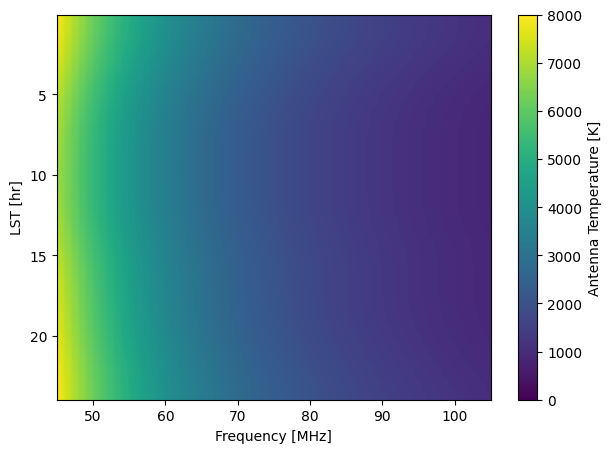

In [3]:
lst, freq, temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
FLOW = 45
FHIGH = 105
indx = (freq >= FLOW) * (freq <= FHIGH)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

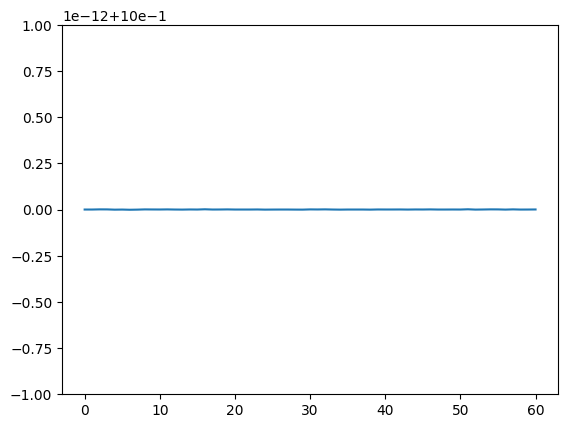

In [4]:
cut = nspec % NBINS
if cut == 0:
    fg_bin = temp.copy()
else:
    fg_bin = temp[:-cut]
fg_bin = fg_bin.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)  # this discards the last 6 min integration

plt.figure()
plt.plot(fg_bin.T/fg_mean[:, None])
plt.show()

### Global signal

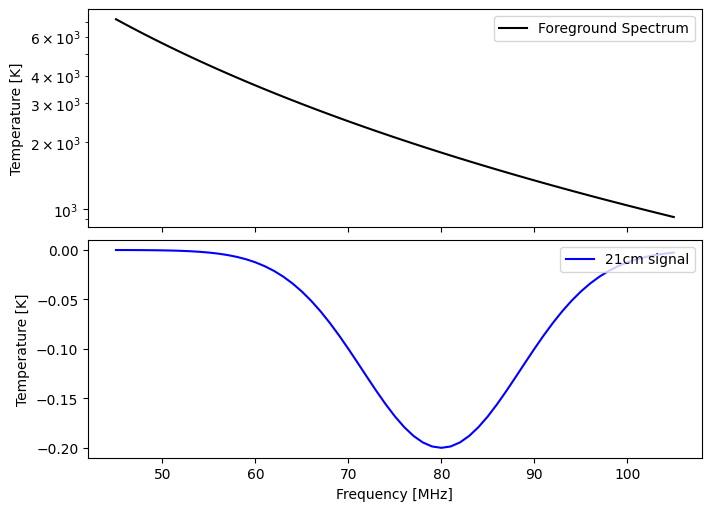

In [5]:
# injected global signal
def gauss(f, a=-0.2, w=20, nu21=80):
    """
    Gaussian in terms of frequency, amplitude, FWHM, and center freq. Default parameters are the ones used in Monsalve et al. 2023b.
    """
    return a * np.exp(-1/2 *((f-nu21) / w)**2 *8*np.log(2))

TRUE_PARAMS = {"a": -0.2, "w": 20, "nu21": 80}
TRUE_T21 = gauss(freq, **TRUE_PARAMS)

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, TRUE_T21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Foreground model

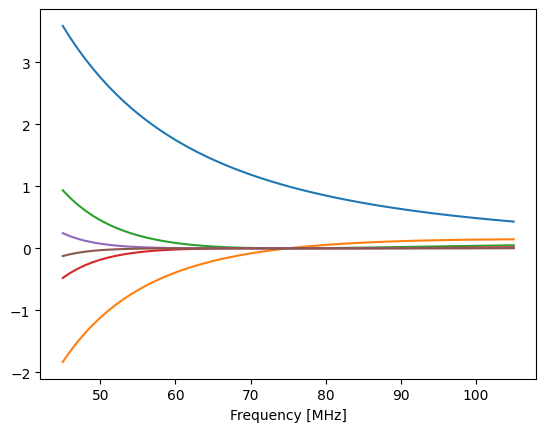

In [6]:
A = ms.utils.design_mat(freq, 6)

plt.figure()
for i in range(A.shape[1]):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

# Chromaticity correction

['ant_temp', 'freq', 'lst']


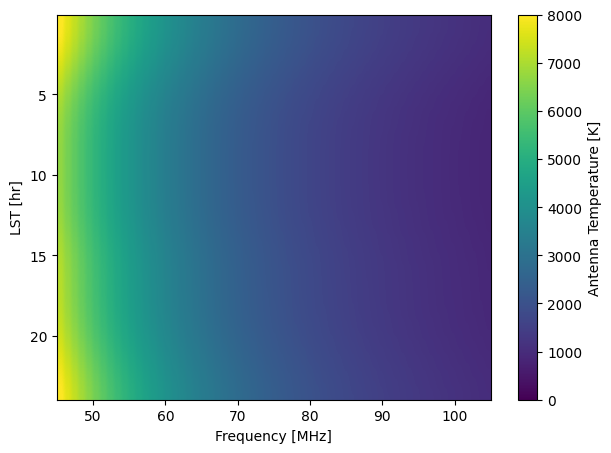

In [7]:
ac_temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains_achromatic_75MHz.hdf5",
    print_key=True,
)[-1]

ac_temp = ac_temp[:, indx]


plt.figure(figsize=(7,5))
im = plt.imshow(
    ac_temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

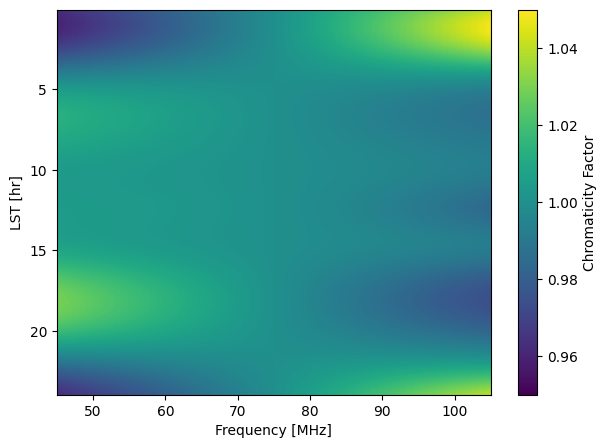

In [8]:
chrom = temp / ac_temp  # chromaticity factor (BF)

plt.figure(figsize=(7,5))
im = plt.imshow(
    chrom, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0.95, 1.05)
plt.colorbar(label="Chromaticity Factor")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

In [11]:
ctemp = (temp+TRUE_T21) / chrom  # = ac temp, the waterfall due to achromatic beam

print(np.allclose(ctemp, ac_temp))
if cut == 0:
    binned = ctemp.copy()
else:
    binned = ctemp[:-cut]
binned = binned.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
chrom_mean = chrom.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
print(chrom_mean.shape)

tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = ctemp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio)


False
(1, 61)


In [23]:
s_christian = np.sqrt(1/sigma_inv[0])
s_raul = (binned[0] / binned[0][freq == 75]) * 3e-3
print(np.max(np.abs(s_christian-s_raul)))
print(np.allclose(s_raul, s_christian))

1.734723475976807e-18
True


In [24]:
noise_raul = np.random.normal(scale=s_raul)

In [25]:
NFG = [5]
#lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise_raul, np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]

In [26]:
nparticles = 64
bounds = np.array([[-1., 0.], [1., 60.], [45., 105.]]) #XXX
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus) 
results = sampler.run_sampler(lst_bins, add_samples=10000)

Iter: 44it [01:07,  1.53s/it, beta=1, calls=7488, ESS=0.989, logZ=-46.6, accept=0.247, N=2, scale=1.18, corr=0.643]       
Iter: 157it [00:19,  8.17it/s, beta=1, calls=33984, ESS=0.95, logZ=-46.6, accept=0.26, N=3, scale=1.28, corr=0.688] 


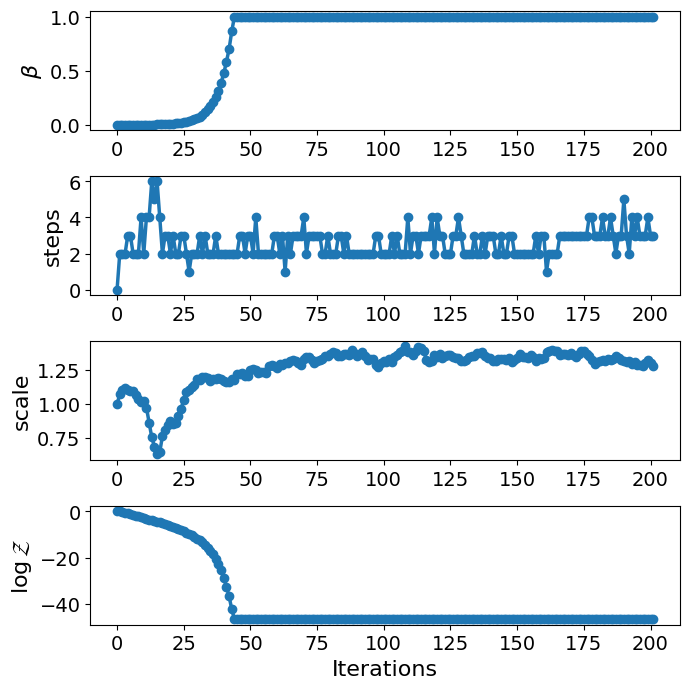

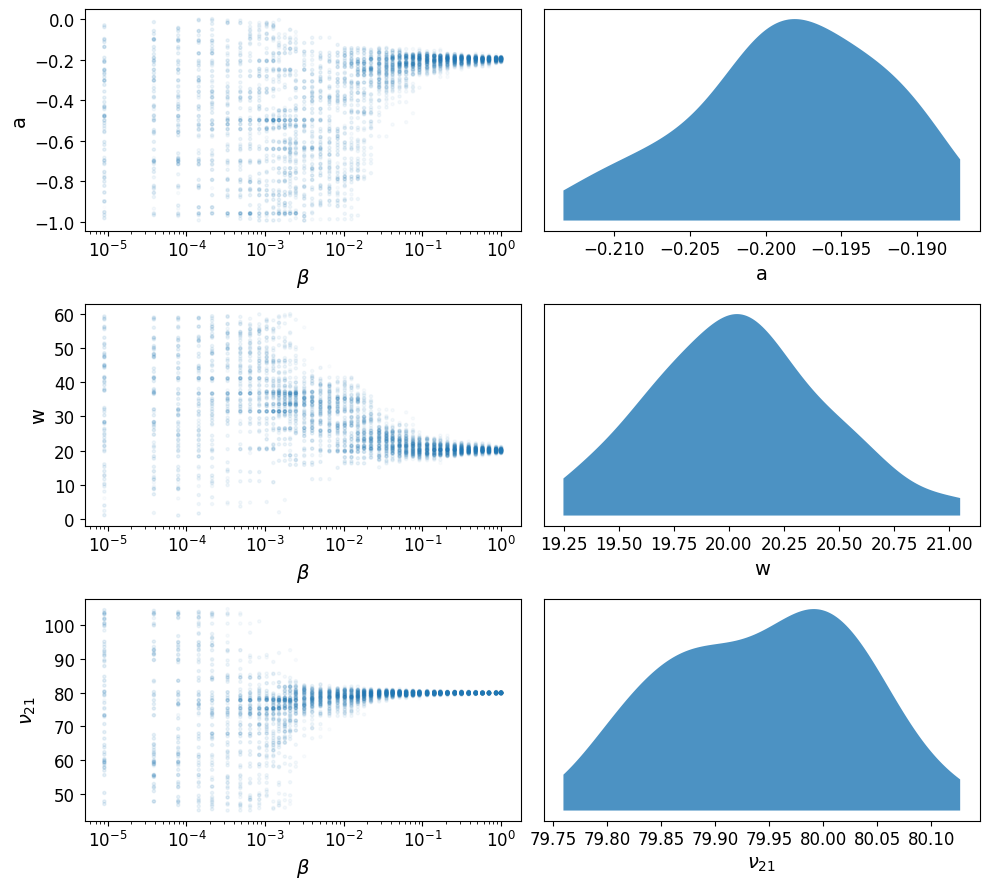

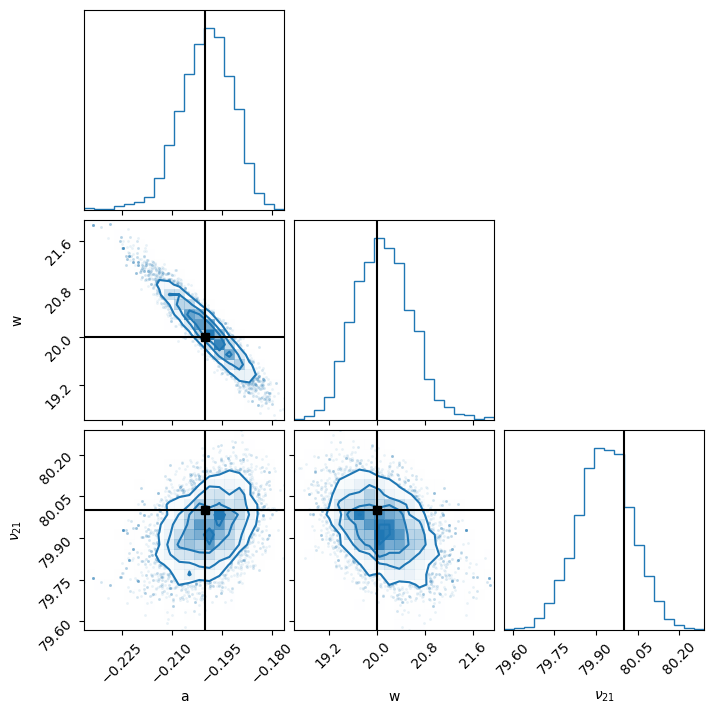

In [27]:
_ = pc.plotting.run(results, width=7, height=7)
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)
_ = pc.plotting.corner(results, labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

In [28]:
estimated_params = np.mean(results['samples'], axis=0)
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.19951582 20.113945   79.934845  ]
Standard deviation values =  [0.00777578 0.4649077  0.09815472]

[0.24267772 0.56649756 0.08151017]
[0.06226778 0.24509167 0.66379922]


## With my noise

In [29]:
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]

In [30]:
nparticles = 64
bounds = np.array([[-1., 0.], [1., 60.], [45., 105.]]) #XXX
ndims = len(bounds)
sampler = ms.Sampler(nparticles, ndims, bounds, n_cpus=n_cpus) 
results = sampler.run_sampler(lst_bins, add_samples=10000)

Iter: 45it [01:24,  1.87s/it, beta=1, calls=8256, ESS=0.996, logZ=-42.9, accept=0.281, N=2, scale=1.17, corr=0.719]       
Iter: 157it [00:17,  9.19it/s, beta=1, calls=31488, ESS=0.95, logZ=-42.9, accept=0.247, N=2, scale=1.26, corr=0.668]


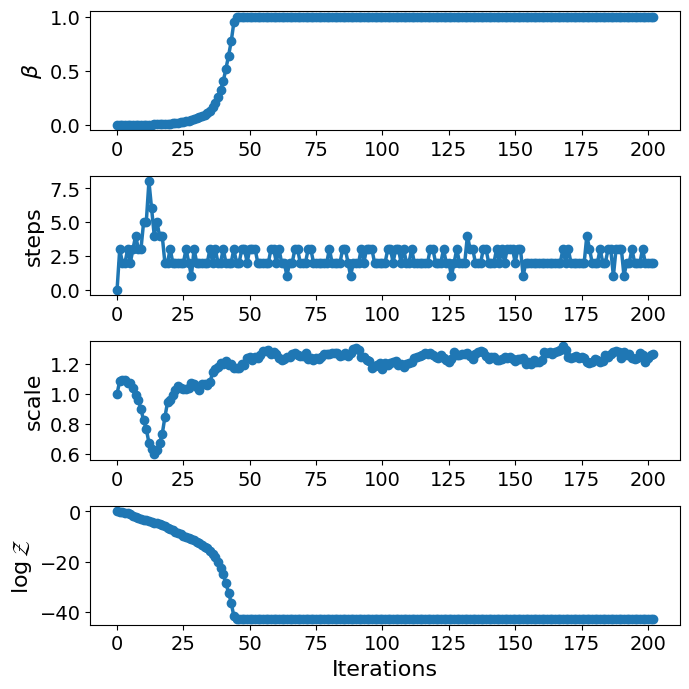

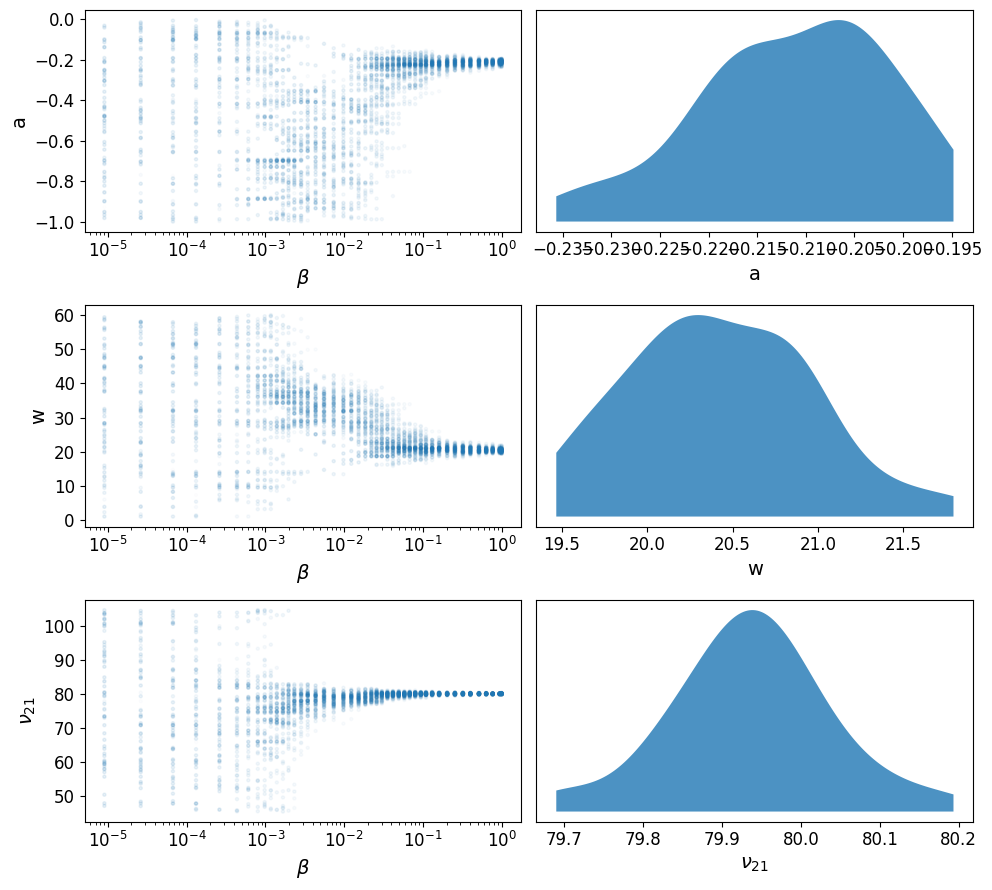

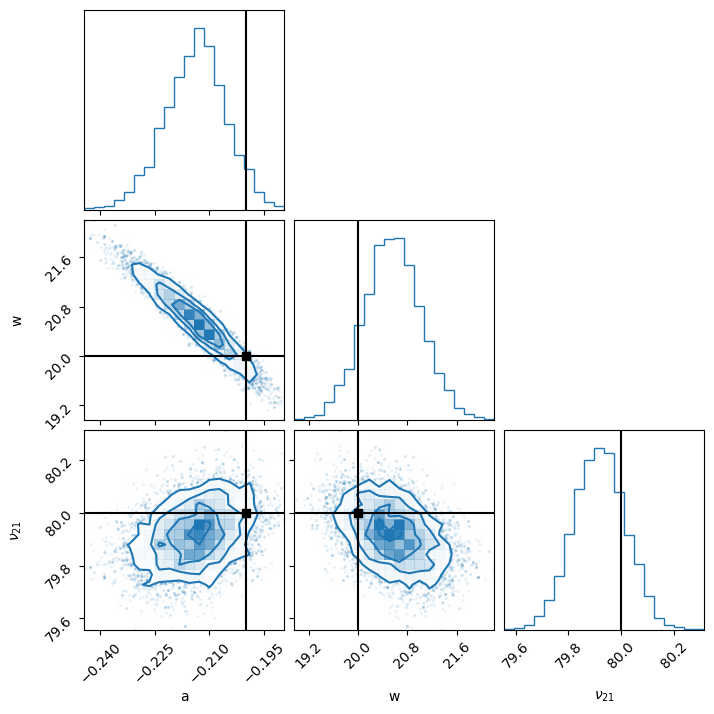

In [31]:
_ = pc.plotting.run(results, width=7, height=7)
labels = ["a", "w", "$\\nu_{21}$"]
_ = pc.plotting.trace(results, labels=labels)
_ = pc.plotting.corner(results, labels=labels, truths=list(TRUE_PARAMS.values()), truth_color="k")

In [32]:
estimated_params = np.mean(results['samples'], axis=0)
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.21376793 20.565277   79.91884   ]
Standard deviation values =  [0.00838333 0.4597921  0.09843479]

[6.44059696 2.74869673 0.1015549 ]
[1.64229785 1.22941888 0.82452046]
